In [85]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

## Loading and splitting the dataset

In [86]:
# loading the dataset
PATH = '/Users/marco/PROJECTS/F422_PROJECT'

X_raw = np.load(PATH + '/data/guided/guided_dataset_X.npy')
Y_raw = np.load(PATH + '/data/guided/guided_dataset_Y.npy')

# splitting into train and val
# we use four of the five experiments for train, and we validate on the fifth
X_raw_train  = X_raw[:4, :, :]
X_raw_val  = X_raw[4, :, :]

Y_raw_train  = Y_raw[:4, :, :]
Y_raw_val  = Y_raw[4, :, :]

## Time window extraction and visualization

In [87]:
def get_time_window(x, stop, size):
    # extracts a time window from a np array x of dimensions k + 1
    # assumes that the time dimension is the last one
    # so x[i1,...,ik,:] is a signal for every i1,...,ik
    return x[...,stop-size:stop]

def visualize_time_window(time_window):
    # visualizes the eight signals of a time window
    # time_window is a np array of shape (8, size) where size is the time window size 
    size = time_window.shape[1]

    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    axs_flat = axs.flatten()

    for i in range(8):
        axs_flat[i].plot(np.arange(size), time_window[i])
        axs_flat[i].set_title(f'Sensor {i}')
        axs_flat[i].set_ylim(-1000,1000)
        axs_flat[i].grid(True)

##### Example usage

In [88]:
T = 5000 # example ending time
size = 500 # example size

time_window = get_time_window(
    X_raw_train,
    stop = T,
    size = size)

time_window.shape

(4, 8, 500)

The extracted time window has shape `(4,8,500)`, i.e. four sets of eight signals of length 500ms

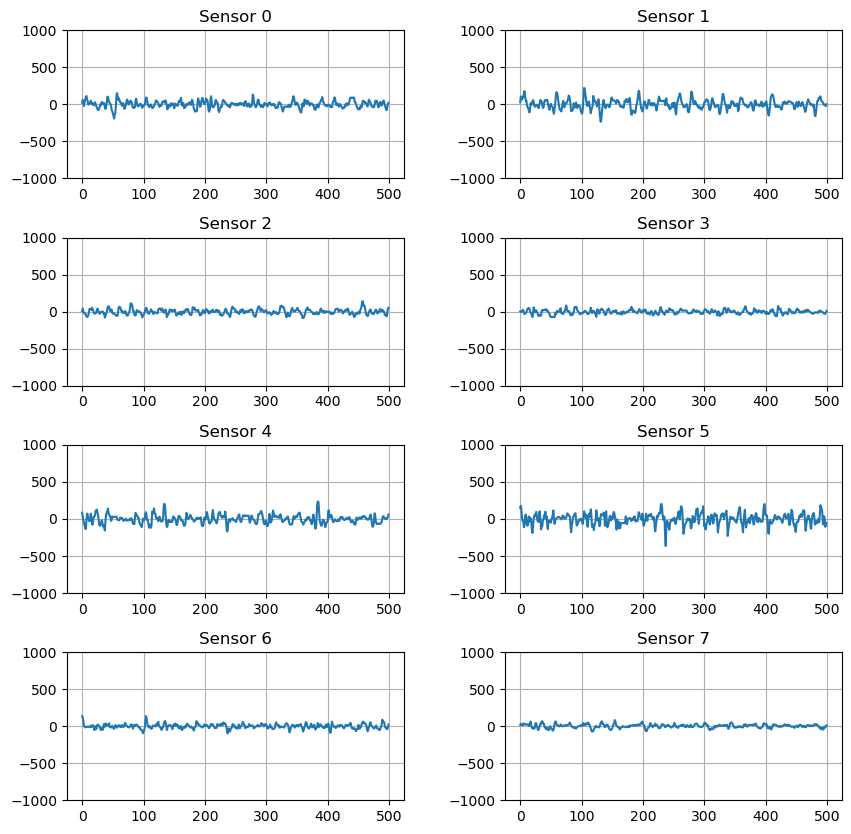

In [89]:
time_window_0 = time_window[0] # getting the first set of signals from the extracted time window

visualize_time_window(time_window[0])

## Time domain feature extraction

In [90]:
# features in the time domain from the project description
MAV = lambda x: np.mean(np.abs(x)) # mean absolute value
RMS = lambda x: np.mean(x**2)**0.5 # root mean square
VAR = lambda x: np.var(x, ddof=1) # variance
STD = lambda x: np.std(x, ddof=1) # standard deviation
ZC = lambda x: np.sum(x[:-1]*x[1:] < 0) # zero crossing
MPR = lambda x, sigma: np.mean(np.abs(x) > sigma) # myopulse percentage rate

# additional features in the time domain from the paper
MAA = lambda x: np.max(np.abs(x)) # maximum absolute amplitude
WL = lambda x: np.sum(abs(x[1:]-x[:-1])) # waveform length
SSC = lambda x: np.sum(-(x[2:]-x[1:-1])*(x[1:-1]-x[:-2]) > 0) # slope sign changes
WA = lambda x: np.sum(abs(x[1:]-x[:-1]) - STD(x) > 0) # wilson amplitude
MFL = lambda x: np.log((np.sum((x[1:]-x[:-1])**2))**0.5) # maximum fractal length
KRT = lambda x: sp.stats.kurtosis(x, bias=False) # kurtosis
# still to implement: hurst exponent, sample entropy

In [91]:
def get_feature_from_time_window(x, stop, size, fun, **kwargs):
    # extract a time domain feature from an array x of d+1 dimensions
    # the time domain feature is fun applied to the time window x[...,stop-size:stop] with keyword arguments kwargs
    # thus if x has shape (k1,...,kd,N) the return array has shape (k1,...,kd)
    # assumes that the time dimension is the last one
    time_window = get_time_window(x, stop, size)
    return np.apply_along_axis(fun, -1, time_window, **kwargs)
    
def get_labels_from_time(y, time):
    # extracts the labels at a given time
    # assumes that the time dimension is the last one
    return y[...,time]

In [92]:
# dictionary collecting the various time domain feature functions
# keys are the function names, values are pairs with function handles and keyword arguments
time_domain_features = {
    'MAV':  (MAV,   {}),
    'RMS':  (RMS,   {}),
    'VAR':  (VAR,   {}),
    'STD':  (STD,   {}),
    'ZC':   (ZC,    {}),
    'MPR':  (MPR,   {'sigma': 0.3}), # change this when needed 
    'MAA':  (MAA,   {}),
    'WL':   (WL,    {}),
    'SSC':  (SSC,   {}),
    'WA':   (WA,    {}),
    'MFL':  (MFL,   {}),
    'KRT':  (KRT,   {}),
}

In [109]:
# regularly spaced endpoints for the time windows
size = 500
step = 100
stops = np.arange(size, X_raw_train.shape[-1], step)

n_windows = len(stops)
n_features = len(time_domain_features)

features_train = np.zeros((4, 8, n_windows, n_features))
labels_train = np.zeros((4, 51, n_windows))

for i in range(n_windows):
    labels_train[:, :, i] = Y_raw_train[:, :, stops[i]-1]
    for key, j in zip(time_domain_features, range(n_features)):
        fun, kwargs = time_domain_features[key]
        features_train[:, :, i, j] = get_feature_from_time_window(X_raw_train, stops[i], size, fun, **kwargs)

features_train = features_train.transpose(0,2,1,3).reshape(4*n_windows, 8*n_features)
labels_train = labels_train.transpose(0,2,1).reshape(4*n_windows, 51)

In [115]:
# organize data in pandas dataframes for easier visualization
features_col_names = []
for i in range(8):
    features_col_names = features_col_names + [key + f'_{i}' for key in time_domain_features]

labels_col_names = []
for i in range(17):
    labels_col_names += [f'p_{i}', f'y_{i}', f'r_{i}'] # pitch, yaw, roll for each joint

df_predictors = pd.DataFrame(
    features_train,
    columns = features_col_names)

df_labels = pd.DataFrame(
    labels_train,
    columns = labels_col_names)

In [116]:
df_predictors.head(10)

,MAV_0,RMS_0,VAR_0,STD_0,ZC_0,MPR_0,MAA_0,WL_0,SSC_0,WA_0,...,VAR_7,STD_7,ZC_7,MPR_7,MAA_7,WL_7,SSC_7,WA_7,MFL_7,KRT_7
0,6.701652,8.662048,75.033941,8.662213,163.0,0.984,37.924568,3283.141970,261.0,155.0,...,44.911897,6.701634,155.0,0.964,25.145532,2819.547727,289.0,165.0,5.089543,0.086964
1,6.989386,9.044132,81.695415,9.038552,158.0,0.980,37.924568,3373.610681,266.0,145.0,...,43.265571,6.577657,156.0,0.968,25.145532,2767.701023,292.0,170.0,5.077427,0.102537
2,7.234831,9.497249,90.339397,9.504704,157.0,0.982,41.718251,3397.715145,265.0,133.0,...,42.576382,6.525058,150.0,0.970,25.145532,2715.860674,293.0,171.0,5.052410,0.029208
3,7.300941,9.354462,87.673528,9.363414,147.0,0.980,41.718251,3272.207442,266.0,129.0,...,39.320283,6.270589,147.0,0.968,20.126507,2669.629943,293.0,180.0,5.022122,-0.154757
4,7.514818,9.630788,92.686618,9.627389,133.0,0.976,41.718251,3355.196511,272.0,132.0,...,39.404129,6.277271,151.0,0.956,19.922129,2627.318665,297.0,175.0,5.003535,-0.104477
5,9.718116,14.565290,212.466192,14.576220,122.0,0.978,97.447124,3752.638914,266.0,66.0,...,39.309924,6.269763,157.0,0.958,19.922129,2622.449349,298.0,169.0,4.997758,-0.094652
6,19.672748,36.844278,1358.997712,36.864586,114.0,0.982,222.477835,6487.968635,235.0,35.0,...,1359.583750,36.872534,152.0,0.962,344.394781,5336.628378,269.0,22.0,6.332730,38.999288
7,30.283917,50.928300,2598.668986,50.977142,111.0,0.982,224.302565,10250.314281,219.0,59.0,...,4775.537697,69.105265,147.0,0.964,386.615631,11084.602035,244.0,51.0,6.958940,10.755856
8,36.808878,55.149652,3047.522230,55.204368,109.0,0.990,224.302565,12648.034461,191.0,74.0,...,5078.742590,71.265297,144.0,0.974,386.615631,12585.022529,229.0,52.0,6.987415,9.335772
9,41.694484,58.079693,3379.763754,58.135736,112.0,0.996,224.302565,14306.679567,181.0,75.0,...,6406.965304,80.043521,132.0,0.988,386.615631,15965.151554,207.0,58.0,7.101643,5.881592


In [117]:
df_labels.head(10)

,p_0,y_0,r_0,p_1,y_1,r_1,p_2,y_2,r_2,p_3,...,r_13,p_14,y_14,r_14,p_15,y_15,r_15,p_16,y_16,r_16
0,41.695093,-64.842301,-33.443285,29.725702,-5.962789,-16.203879,-7.114659,7.268299,-38.638318,8.864030,...,-5.8475,9.948092,7.320277,-13.119717,-6.990742,7.141302,-82.849937,-2.406158,-3.836331,-71.758591
1,41.856725,-64.987627,-34.053168,29.527446,-7.079870,-16.756121,-7.172260,7.313855,-37.572158,8.813885,...,-5.8475,9.901287,6.557793,-14.365425,-6.997376,7.199550,-84.147718,-2.413121,-3.815299,-72.245742
2,42.037301,-65.154275,-34.742105,29.121584,-9.209879,-17.799463,-7.266052,7.384312,-35.869297,8.742956,...,-5.8475,9.700565,6.874098,-18.650461,-6.999325,7.219493,-84.590933,-2.404969,-3.840299,-71.669479
3,42.476892,-65.580232,-36.455065,28.900968,-10.293290,-18.324961,-7.386346,7.468662,-33.735479,8.700053,...,-5.8475,9.641159,6.690028,-20.022726,-6.993066,7.161539,-83.299993,-2.388397,-3.888101,-70.561532
4,42.907338,-66.027120,-38.185945,29.091843,-9.358777,-17.871938,-7.405286,7.481341,-33.404393,8.626102,...,-5.8475,9.543176,5.693055,-22.483715,-6.985400,7.102579,-81.983126,-2.357759,-3.969794,-68.651315
5,40.589629,-64.014877,-29.550268,29.030873,-9.659962,-18.018160,-7.735229,7.677470,-27.823082,8.835160,...,-5.8475,9.861977,5.822666,-15.428695,-6.843345,6.568743,-69.711802,-2.119679,-4.428288,-57.325311
6,27.542342,-60.979485,7.986728,30.527569,-0.572677,-13.493394,-8.182122,7.881075,-20.670890,9.749078,...,-5.8475,11.240221,8.276289,14.478835,-5.802582,5.271212,-32.076612,-1.250055,-5.270765,-30.584650
7,29.122230,-60.782611,3.888265,30.913673,2.623200,-11.863197,-8.449838,7.972524,-16.547378,10.578534,...,-5.8475,11.145801,11.043358,13.801232,-5.389908,5.058390,-21.747534,-0.933852,-5.430884,-22.828374
8,29.880099,-60.735910,1.909748,30.914911,2.634544,-11.857402,-8.561377,8.004285,-14.856453,10.792034,...,-5.8475,11.022367,10.738143,10.998302,-5.153728,4.976324,-16.193129,-0.727696,-5.508012,-18.015304
9,29.478131,-60.755677,2.960992,30.889003,2.388147,-11.983950,-8.565159,8.005332,-14.798603,10.876012,...,-5.8475,10.909218,11.007788,8.762058,-4.986901,4.933361,-12.368837,-0.565194,-5.555363,-14.315789
